In [3]:
import os
import cv2
import numpy as np

#Encoding and Split data into Train/Test Sets
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

#Tensorflow Keras CNN Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop

#Plot Images
import matplotlib.pyplot as plt


2022-11-24 14:58:08.050937: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Read each image and create a label for each with the name of the folder 

In [4]:

folder_dir = '/Users/casonberkenstock/Final_Project/critter_data'
data = []
label = []

SIZE = 128 #Crop the image to 128x128

# set up labels from the name of each training photo folder
for folder in os.listdir(folder_dir):
    #ignore .DS_Store
    if not folder.startswith('.'):
        for file in os.listdir(os.path.join(folder_dir, folder)):
                # get jpegs 
                if not file.startswith('.'):
                    if file.endswith("jpg"):
                        #label with the folder name 
                        label.append(folder)
                        img = cv2.imread(os.path.join(folder_dir, folder, file))
                        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        im = cv2.resize(img_rgb, (SIZE,SIZE))
                        data.append(im)
                    else:
                        continue

In [5]:
# Now, I believe the data and labels are correctly formed 
len(label) == len(data)

True

### Convert image data to numpy arrays

In [6]:
data_arr = np.array(data)
label_arr = np.array(label)

### Label encoder to normalize data 

In [7]:
encoder = LabelEncoder()
y = encoder.fit_transform(label_arr)
y = to_categorical(y,6)
X = data_arr/255

### Split data into 80% train, 20% test 

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=10)

## Construct nueral network for species recognition 

In [20]:
# Use a sequential model because each layer has one input tensor (np.array) and one output tensor 
model = Sequential()

# implement simple Convolutional Neural Network (CNN) with Conv2D and 64 filters 
# kernel_size specifying the width and height of the 2D convolution window
# chose 3 beacause input images size = 128 
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu', input_shape = (SIZE,SIZE,3)))

# filters: Layers early in the network architecture (i.e., closer to the actual input image) 
# learn fewer convolutional filters while layers deeper in the network 
# (i.e., closer to the output predictions) will learn more filters.

# Max pooling is used to reduce the spatial dimensions of the output volume
model.add(MaxPooling2D(pool_size=(2,2)))

# padding = same so that the output volume size matches the input volume size
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same',activation ='relu'))
#model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same',activation ='relu'))

model.add(MaxPooling2D(pool_size=(2,2)))

# converting multi-dimensional array into one dimensional flatten array or say single dimensional array
model.add(Flatten())

# Dense Layer is used to classify image based on output from convolutional layers.
model.add(Dense(128, activation='relu'))
# Each Layer in the Neural Network contains neurons, which compute the weighted average of its input and this weighted average is passed through a non-linear function, called as an “activation function”.
# in this case, activation function = relu 
model.add(Dense(64, activation='relu'))

# randomly selected neurons (50%) are ignored during training. They are “dropped out” randomly
# (prevent overfitting on the training data)
model.add(Dropout(rate=0.5))

#Softmax is an activation function that scales numbers/logits into probabilities. The output of a Softmax is a vector (say v ) with probabilities of each possible outcome. 
model.add(Dense(6, activation = "softmax"))



### Create more training images to prevent overfitting

In [21]:
# ImageDataGenerator: getting the input of the original data and further, it makes the transformation of this 
# data on a random basis and gives the output resultant containing only the data that is newly transformed. 
# This will help to avoid overfitting by generating randomly altered training photos 

gen_data = ImageDataGenerator(
        rotation_range=20,
        zoom_range = 0.20,
        width_shift_range=0.3,
        height_shift_range=0.3,
        horizontal_flip=True,
        vertical_flip=True)

gen_data.fit(X_train)


### Compile/train the model 

In [22]:
# use adam optimizer algorithm for optimization technique for gradient descent
# loss= cat_cross: Used as a loss function for multi-class classification model where there are two or more output labels
# metrics= accuracy: Calculates how often predictions equal labels
model.compile(optimizer=Adam(lr=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
batch_size=32
epochs= 64




In [23]:
history = model.fit_generator(gen_data.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs,
                              validation_data = (X_test,y_test),
                              verbose = 1)

/opt/anaconda3/envs/Ironhack/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Epoch 1/64
20/20 [==============================] - 126s 6s/step - loss: 1.8592 - accuracy: 0.1745 - val_loss: 1.7910 - val_accuracy: 0.1625
Epoch 2/64
20/20 [==============================] - 109s 6s/step - loss: 1.7923 - accuracy: 0.1635 - val_loss: 1.7923 - val_accuracy: 0.1562
Epoch 3/64
20/20 [==============================] - 105s 5s/step - loss: 1.7896 - accuracy: 0.1950 - val_loss: 1.7927 - val_accuracy: 0.1375
Epoch 4/64
20/20 [==============================] - 105s 5s/step - loss: 1.7882 - accuracy: 0.1981 - val_loss: 1.7939 - val_accuracy: 0.1562
Epoch 5/64
20/20 [==============================] - 104s 5s/step - loss: 1.7899 - accuracy: 0.1840 - val_loss: 1.7940 - val_accuracy: 0.1562
Epoch 6/64
20/20 [==============================] - 106s 5s/step - loss: 1.7881 - accuracy: 0.1651 - val_loss: 1.7944 - val_accuracy: 0.1562
Epoch 7/64
20/20 [==============================] - 114s 6s/step - loss: 1.7866 - accuracy: 0.2013 - val_loss: 1.7953 - val_accuracy: 0.1562
Epoch 8/64
20

Epoch 59/64
20/20 [==============================] - 103s 5s/step - loss: 1.5755 - accuracy: 0.3412 - val_loss: 1.7017 - val_accuracy: 0.3375
Epoch 60/64
20/20 [==============================] - 103s 5s/step - loss: 1.5822 - accuracy: 0.3491 - val_loss: 1.6230 - val_accuracy: 0.3125
Epoch 61/64
20/20 [==============================] - 104s 5s/step - loss: 1.5963 - accuracy: 0.3459 - val_loss: 1.7066 - val_accuracy: 0.3125
Epoch 62/64
20/20 [==============================] - 103s 5s/step - loss: 1.6125 - accuracy: 0.3396 - val_loss: 1.6282 - val_accuracy: 0.3250
Epoch 63/64
20/20 [==============================] - 105s 5s/step - loss: 1.5735 - accuracy: 0.3805 - val_loss: 1.6300 - val_accuracy: 0.3375
Epoch 64/64
20/20 [==============================] - 103s 5s/step - loss: 1.5533 - accuracy: 0.3632 - val_loss: 1.6546 - val_accuracy: 0.3438


### Check the accuracy of the model by outputting photos

In [24]:
# sort files 
cats = np.sort(os.listdir(folder_dir))
categories= cats[1:]

5/5 [==============================] - 7s 1s/step


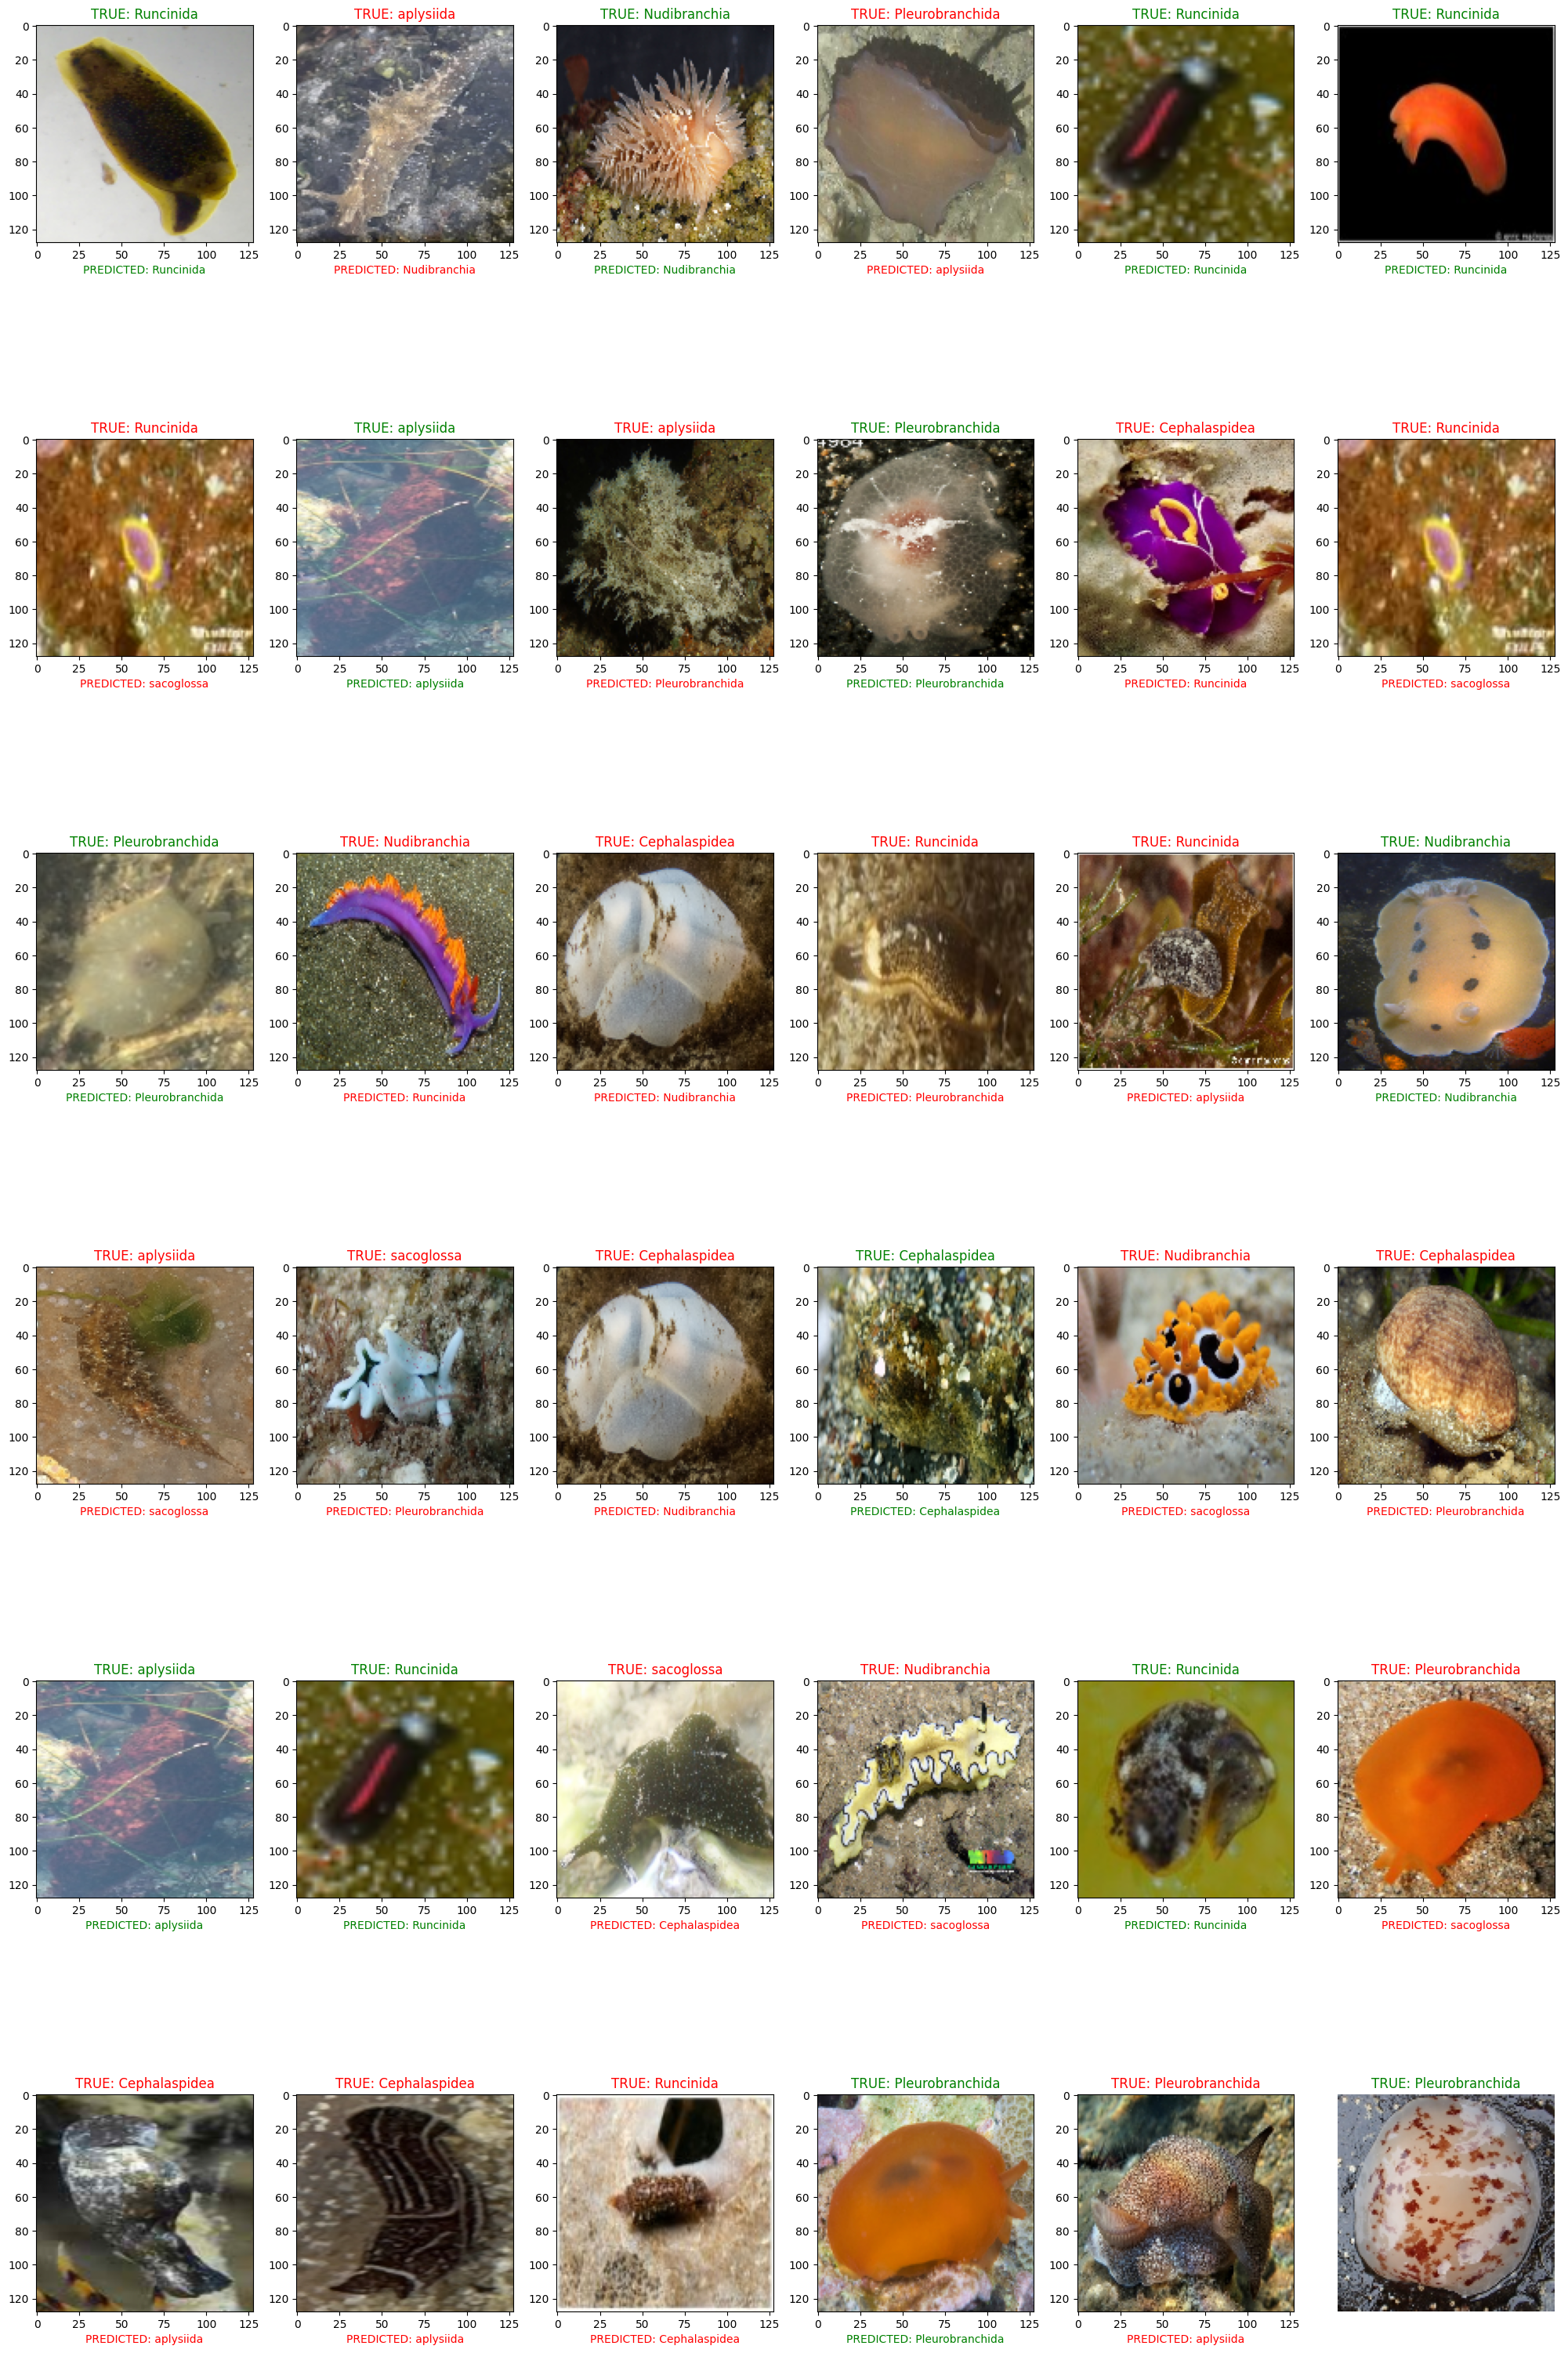

In [26]:
# set up 6x6 subplots 
fig, ax = plt.subplots(6,6, figsize=(25, 40))

for i in range(6):
    for j in range(6):
        k = int(np.random.random_sample() * len(X_test))
        # find class with largest predicted probability using argmax 
        if(categories[np.argmax(y_test[k])] == categories[np.argmax(model.predict(X_test)[k])]):
        # if the max probability of y_test[k] = max prob of X_test[k]: print true category above photo, as well as 
        # the predicted category in GREEN (because they are equal)
            ax[i,j].set_title("TRUE: " + categories[np.argmax(y_test[k])], color='green')
            ax[i,j].set_xlabel("PREDICTED: " + categories[np.argmax(model.predict(X_test)[k])], color='green')
            plt.axis("off")
            ax[i,j].imshow(np.array(X_test)[k].reshape(SIZE, SIZE, 3), cmap='gray')
            
        else:
        # otherwise, print True categroy and the predicted category in RED 
            ax[i,j].set_title("TRUE: " + categories[np.argmax(y_test[k])], color='red')
            ax[i,j].set_xlabel("PREDICTED: " + categories[np.argmax(model.predict(X_test)[k])], color='red')
            plt.axis("off")
            ax[i,j].imshow(np.array(X_test)[k].reshape(SIZE, SIZE, 3), cmap='gray')
            
            
            